In [301]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import cheby1, freqz

from Functions.daub_5_3_lift import daub_5_3_lift
from Functions.idaub_5_3_lift import idaub_5_3_lift
from Functions.daub_5_3_lift_2D import daub_5_3_lift_2D
from Functions.idaub_5_3_lift_2D import idaub_5_3_lift_2D

In [302]:
user_figsize = (12, 6)
user_frsize = (12,8)
user_fontsize = 14
user_ylabel = ['Magnitude, db', 'Phase, deg']

In [303]:
F_SAMPLE = 102400
T_SAMPLE = 1/F_SAMPLE

F_LOW = 100
H_WINDOW = 1/F_LOW

T_FULL = 4*H_WINDOW

N_POINT = int(T_FULL/T_SAMPLE+0.5)
N_FFT = int(H_WINDOW/T_SAMPLE+0.5)
print(N_FFT)

1024


Синтез фильтра

In [304]:
# Crossover frequency.
fc = 1e3

filter_order = 2
filter_mag = 5

b, a = cheby1(filter_order, filter_mag, fc/(F_SAMPLE/2), btype='low')

Частотная характеристика синтезированного фильтра

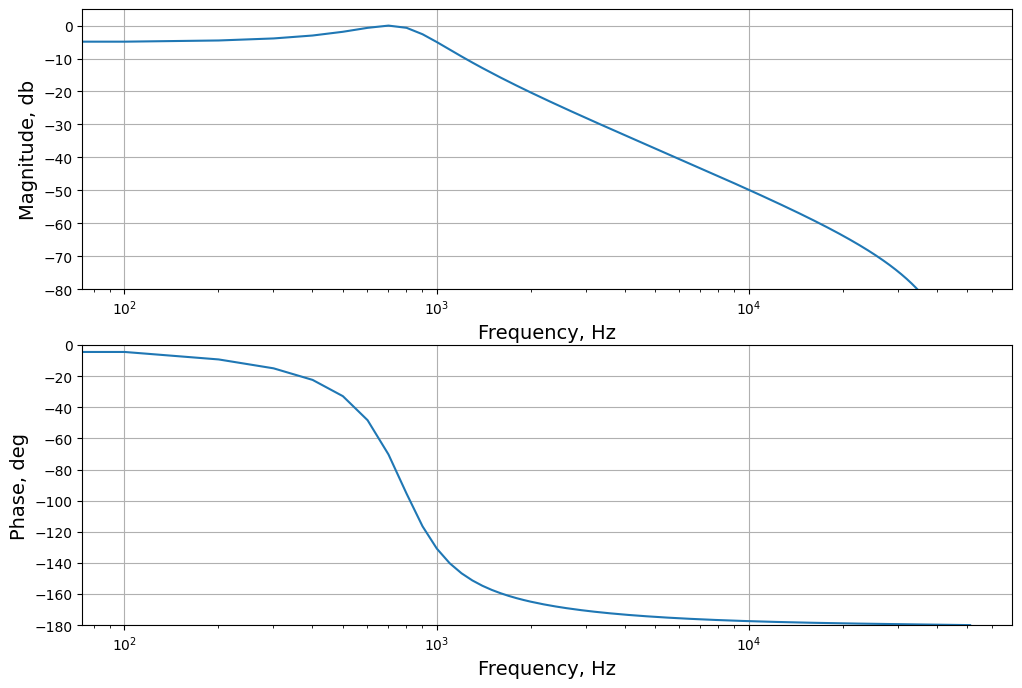

In [305]:
freq_graph = np.linspace(0, F_SAMPLE/2, N_FFT//2)

_, h = freqz(b, a, worN=N_FFT//2)
filter_abs_phase = [20*np.log10(np.abs(h)), np.unwrap(np.angle(h))*180/np.pi]

user_ylim = [[-80, 5], [-180, 0]]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable in zip(axes, filter_abs_phase, user_ylim, user_ylabel):
    ax.plot(freq_graph, plot_var)
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.grid(True)
plt.show()

Массив инжектируемых частот

In [306]:
N_FREQ = int(F_SAMPLE/2/F_LOW) - 1
freq = np.linspace(F_LOW, F_SAMPLE/2-F_LOW, N_FREQ)

Набор сигналов инжекции

In [307]:
t = np.linspace(0, T_FULL-T_SAMPLE, N_POINT)

Xm = 3
phi_x = np.pi/6
NOISE_MAG = 0.01 * Xm

x = np.empty((N_FREQ,), dtype=object)
for k, f in enumerate(freq):
    x[k] = Xm * np.cos(2*np.pi*f*t + phi_x) + np.random.normal(0, NOISE_MAG, N_POINT)

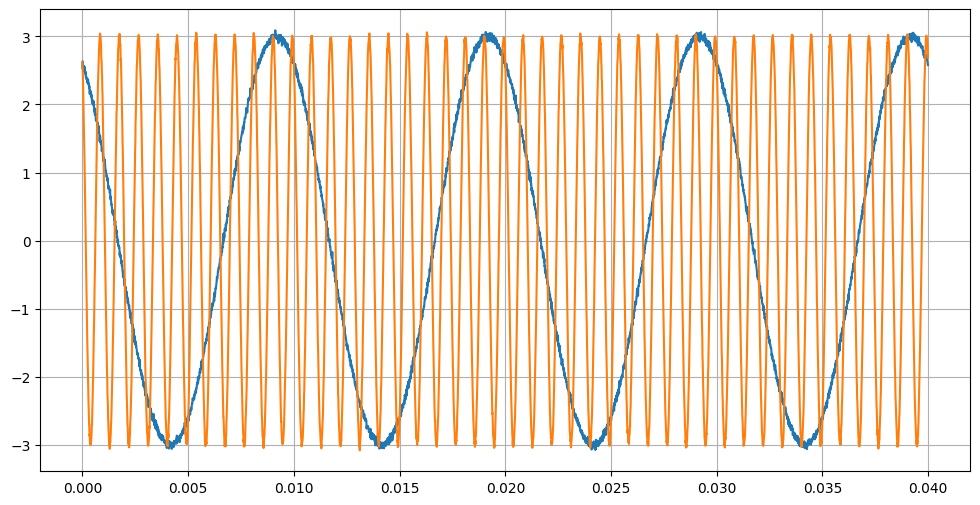

In [308]:
plt.figure(figsize=user_figsize)
plt.plot(t,x[0])
plt.plot(t,x[10])
plt.grid(True)
plt.show()

Модель динамической системы

In [309]:
def IIR_filter(x, b_coeff, a_coeff):
    # Создаем список из нулей.
    y = [0] * len(x)
    for k in range(len(x)):
        for m, b in enumerate(b_coeff):
            if (k-m) >= 0:
                y[k] += b * x[k-m]
        for n, a in enumerate(a_coeff[1:], start=1):
            if (k-n) >= 0:
                y[k] -= a * y[k-n]
    return y

Выходной сигнал системы

In [310]:
y = np.empty((N_FREQ,), dtype=object)
for k, xf in enumerate(x):
    y[k] = IIR_filter(xf, b, a)

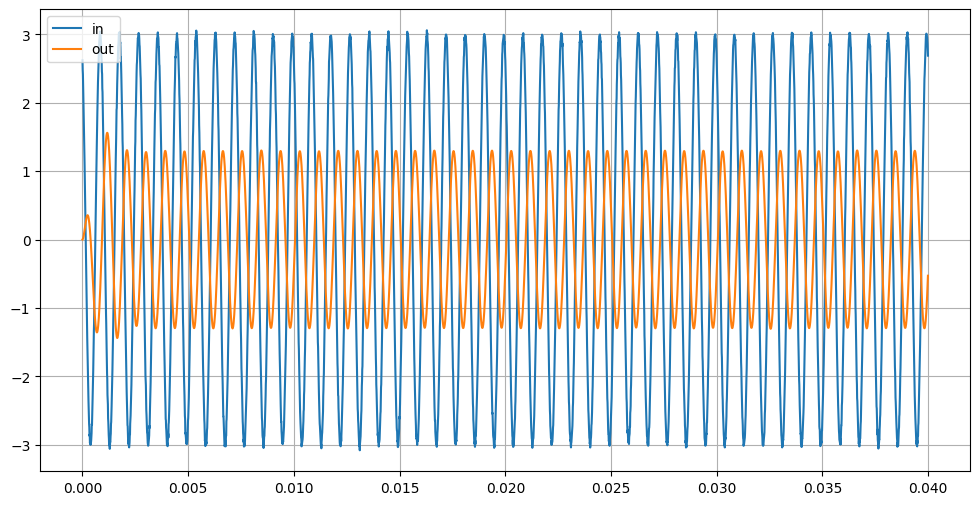

In [311]:
plt.figure(figsize=user_figsize)
plt.plot(t,x[10], label='in')
plt.plot(t,y[10], label='out')
plt.legend()
plt.grid(True)
plt.show()

Частотная характеристика

In [312]:
def freq_resp(x, y, N_FREQ):
    complex_gain = np.zeros((N_FREQ,), dtype=complex)

    for k in range(N_FREQ):
        Xfft = np.fft.fft(x[k][-N_FFT:])[:N_FFT//2]
        Yfft = np.fft.fft(y[k][-N_FFT:])[:N_FFT//2]
        complex_gain[k] = Yfft[k+1]/Xfft[k+1]
    return complex_gain

In [313]:
complex_gain = freq_resp(x, y, N_FREQ)
gain_abs_arg = [20*np.log10(np.abs(complex_gain)), np.unwrap(np.angle(complex_gain))*180/np.pi]

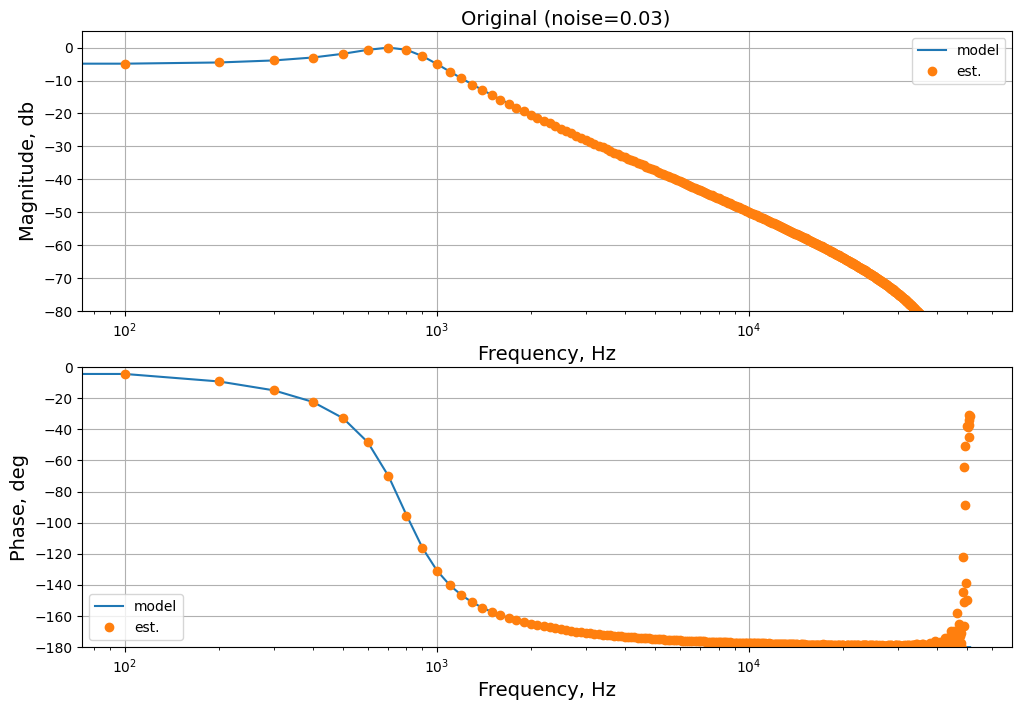

In [314]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(1200, 220, 'Original (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

In [315]:
x_compr = np.empty((N_FREQ,), dtype=object)
y_compr = np.empty((N_FREQ,), dtype=object)

for k, xf in enumerate(x):
    x_coeff = daub_5_3_lift(xf[-N_FFT:], int_flag=False)
    x_coeff[-N_FFT//2:] = 0
    x_compr[k] = idaub_5_3_lift(x_coeff, int_flag=False)

for k, yf in enumerate(y):
    y_coeff = daub_5_3_lift(np.array(yf[-N_FFT:]), int_flag=False)
    y_coeff[-N_FFT//2:] = 0
    y_compr[k] = idaub_5_3_lift(y_coeff, int_flag=False)

complex_gain_compr = freq_resp(x_compr, y_compr, N_FREQ)
gain_abs_arg_compr = [20*np.log10(np.abs(complex_gain_compr)), np.unwrap(np.angle(complex_gain_compr))*180/np.pi]

In [316]:
print(np.array(x_compr[0]).shape)

(1024,)


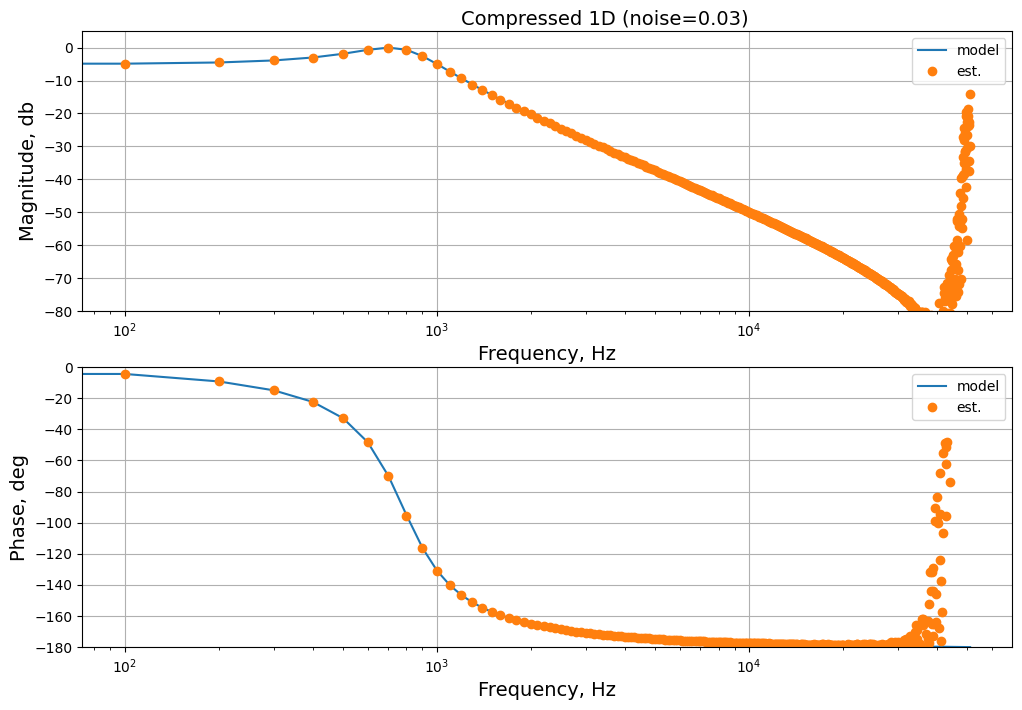

In [317]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_compr):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(1200, 220, 'Compressed 1D (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

Двумерное преобразование

In [318]:
N_ROW = 32
N_COL = 32

N_FIG = 45

In [319]:
x_sq = np.empty((N_FREQ,), dtype=object)
for k, xf in enumerate(x):
    x_sq[k] = xf[-N_FFT:].reshape(N_ROW, -1)

y_sq = np.empty((N_FREQ,), dtype=object)
for k, yf in enumerate(y):
    y_sq[k] = np.array(yf[-N_FFT:]).reshape(N_ROW, -1)

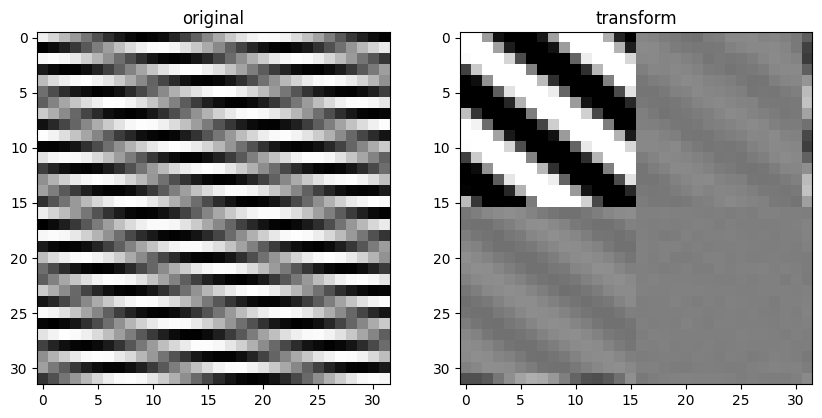

In [320]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs.flat[0].imshow(x_sq[N_FIG], cmap='gray', interpolation='none', vmin=x_sq[N_FIG].min(), vmax=x_sq[N_FIG].max())
axs.flat[0].set_title('original')

axs.flat[1].imshow(daub_5_3_lift_2D(x_sq[N_FIG], int_flag=False), cmap='gray', interpolation='none', vmin=x_sq[N_FIG].min(), vmax=x_sq[N_FIG].max())
axs.flat[1].set_title('transform')
plt.show()

In [321]:
x_compr_2D = np.empty((N_FREQ,), dtype=object)
y_compr_2D = np.empty((N_FREQ,), dtype=object)

for k, xf in enumerate(x_sq):
    x_coeff = np.zeros((N_ROW,N_COL))
    x_coeff[:,:N_COL//2] = daub_5_3_lift_2D(xf, int_flag=False)[:,:N_COL//2]
    x_compr_2D[k] = idaub_5_3_lift_2D(x_coeff, int_flag=False).ravel()

for k, yf in enumerate(y_sq):
    y_coeff = np.zeros((N_ROW,N_COL))
    y_coeff[:,:N_COL//2] = daub_5_3_lift_2D(yf, int_flag=False)[:,:N_COL//2]
    y_compr_2D[k] = idaub_5_3_lift_2D(y_coeff, int_flag=False).ravel()

complex_gain_compr_2D = freq_resp(x_compr_2D, y_compr_2D, N_FREQ)
gain_abs_arg_compr_2D = [20*np.log10(np.abs(complex_gain_compr_2D)), np.unwrap(np.angle(complex_gain_compr_2D))*180/np.pi]

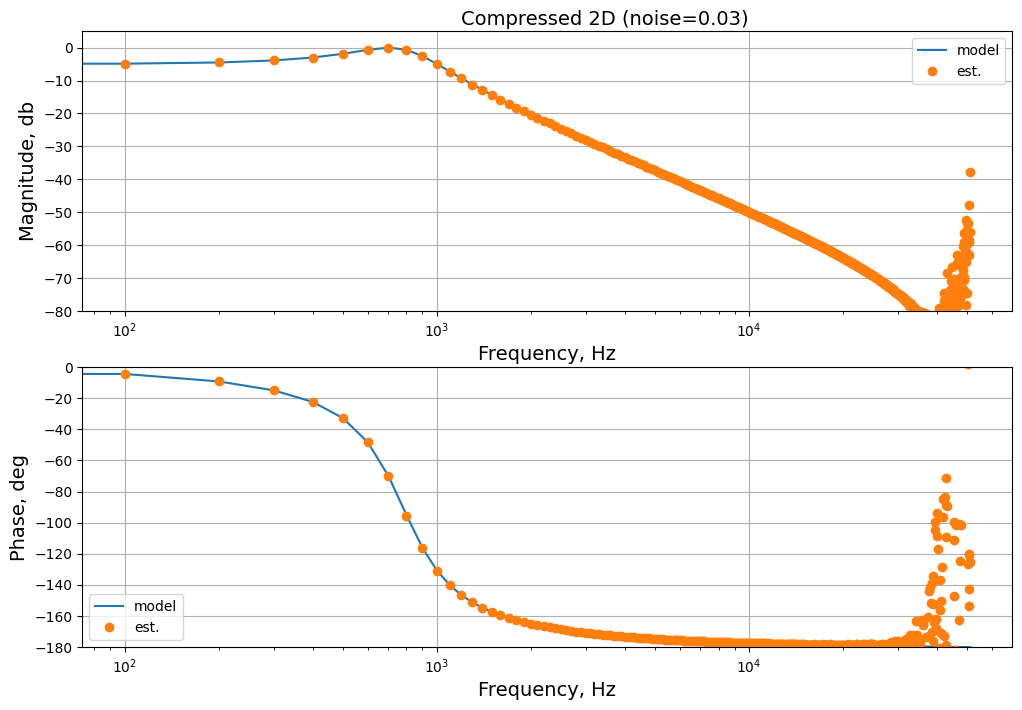

In [322]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_compr_2D):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(1200, 220, 'Compressed 2D (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

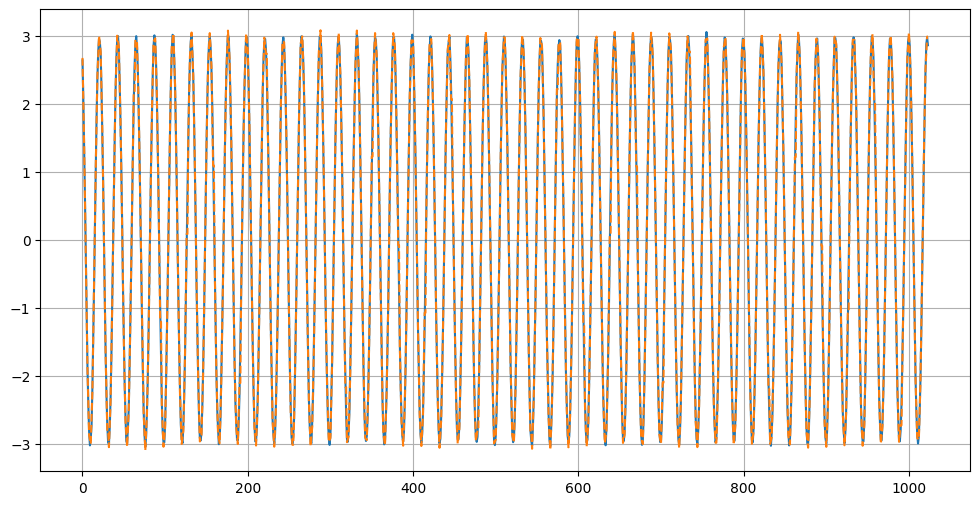

In [323]:
plt.figure(figsize=user_figsize)
plt.plot(x[N_FIG][-N_FFT:])
plt.plot(x_compr_2D[N_FIG], '--')
plt.grid()
plt.show()

In [324]:
from Functions.scanorder import zigzag_order
order = zigzag_order(Nrow=N_ROW, Ncol=N_COL, LH_to_RL=False, init_value=0)

In [325]:
x_compr_2D_zg = np.empty((N_FREQ,), dtype=object)
y_compr_2D_zg = np.empty((N_FREQ,), dtype=object)
x_compr_2D_zg_rev = np.empty((N_FREQ,), dtype=object)
y_compr_2D_zg_rev = np.empty((N_FREQ,), dtype=object)
for k, xf in enumerate(x):
    xf_zigzag = np.zeros_like(order)
    x_coeff   = np.zeros_like(order)
    
    xf_cut = xf[-N_FFT:]
    for m in range(N_COL):
        for n in range(N_ROW):
            xf_zigzag[n,m] = xf_cut[order[n,m]]
    
    x_coeff[-N_ROW//2:,:N_COL//2] = daub_5_3_lift_2D(xf_zigzag, int_flag=False)[-N_ROW//2:,:N_COL//2]
    #x_coeff = daub_5_3_lift_2D(xf_zigzag, int_flag=False)
    
    x_compr_2D_zg[k] = idaub_5_3_lift_2D(x_coeff, int_flag=False)
    
    x_compr_2D_zg_rev[k] = np.zeros_like(xf[-N_FFT:])
    for m in range(N_COL):
        for n in range(N_ROW):
            x_compr_2D_zg_rev[k][order[n,m]] = x_compr_2D_zg[k][n,m]

for k, yf in enumerate(y):
    yf_zigzag = np.zeros((N_ROW,N_COL))
    y_coeff   = np.zeros((N_ROW,N_COL))
    
    yf_cut = yf[-N_FFT:]
    for m in range(N_COL):
        for n in range(N_ROW):
            yf_zigzag[n,m] = yf_cut[order[n,m]]
    
    y_coeff[-N_ROW//2:,:N_COL//2] = daub_5_3_lift_2D(yf_zigzag, int_flag=False)[-N_ROW//2:,:N_COL//2]
    #y_coeff = daub_5_3_lift_2D(yf_zigzag, int_flag=False)
    
    y_compr_2D_zg[k] = idaub_5_3_lift_2D(y_coeff, int_flag=False)
    
    y_compr_2D_zg_rev[k] = np.zeros_like(yf[-N_FFT:])
    for m in range(N_COL):
        for n in range(N_ROW):
            y_compr_2D_zg_rev[k][order[n,m]] = y_compr_2D_zg[k][n,m]

complex_gain_compr_2D_zg = freq_resp(x_compr_2D_zg_rev, y_compr_2D_zg_rev, N_FREQ)
gain_abs_arg_compr_2D_zg = [20*np.log10(np.abs(complex_gain_compr_2D_zg)), np.unwrap(np.angle(complex_gain_compr_2D_zg))*180/np.pi]

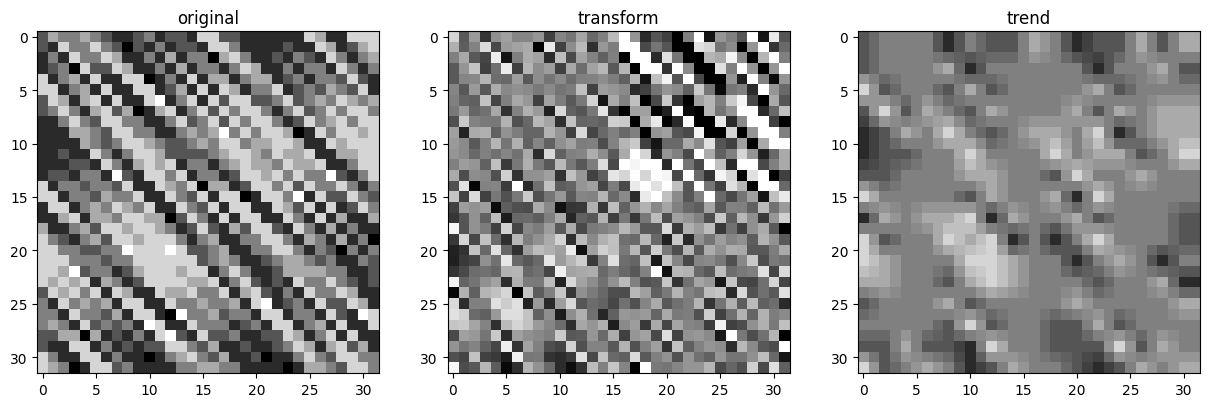

In [326]:
x_zigzag = np.zeros_like(order)
x_fig = x[N_FIG]
for m in range(N_COL):
    for n in range(N_ROW):
        x_fig_cut = x_fig[-N_FFT:]
        x_zigzag[n,m] = x_fig_cut[order[n,m]]

coeff_zigzag = daub_5_3_lift_2D(x_zigzag, int_flag=False)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
axs.flat[0].imshow(x_zigzag, cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[0].set_title('original')

axs.flat[1].imshow(coeff_zigzag, cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[1].set_title('transform')

axs.flat[2].imshow(x_compr_2D_zg[N_FIG], cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[2].set_title('trend')
plt.show()

In [327]:
np.sum((x_zigzag - x_compr_2D_zg[N_FIG])**2)

1641.4375

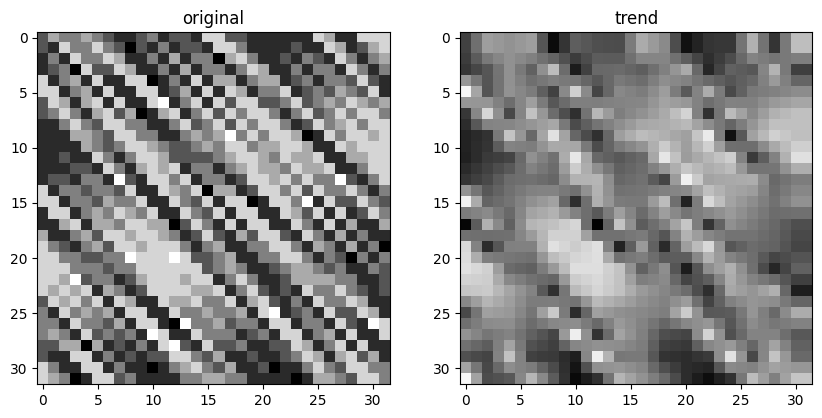

In [328]:
coeff_zigzag_masked = np.zeros_like(coeff_zigzag)
coeff_zigzag_masked[-N_ROW//2:,:N_COL//2] = coeff_zigzag[-N_ROW//2:,:N_COL//2]

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs.flat[0].imshow(x_zigzag, cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[0].set_title('original')

axs.flat[1].imshow(idaub_5_3_lift_2D(coeff_zigzag_masked, int_flag=False), cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[1].set_title('trend')
plt.show()

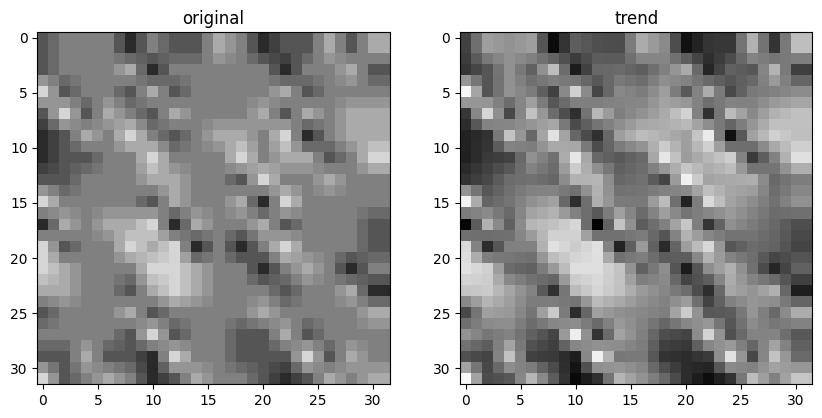

In [329]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs.flat[0].imshow(x_compr_2D_zg[N_FIG], cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[0].set_title('original')

axs.flat[1].imshow(idaub_5_3_lift_2D(coeff_zigzag_masked, int_flag=False), cmap='gray', interpolation='none', vmin=x_zigzag.min(), vmax=x_zigzag.max())
axs.flat[1].set_title('trend')
plt.show()

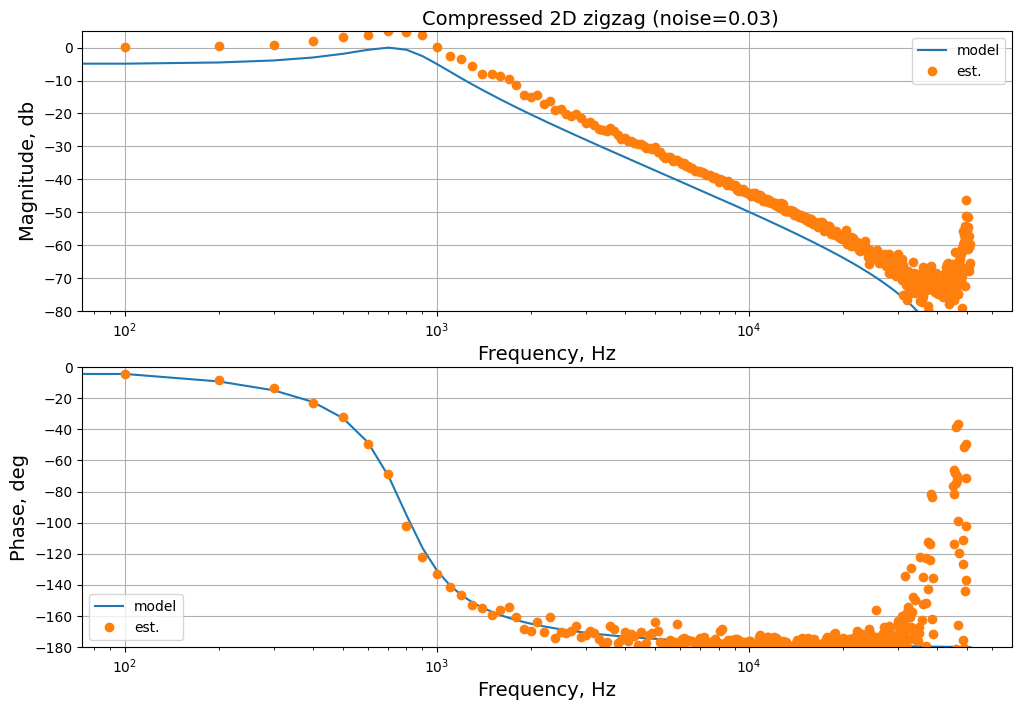

In [330]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=user_frsize)
for ax, plot_var, ylim, ylable, gain in zip(axes, filter_abs_phase, user_ylim, user_ylabel, gain_abs_arg_compr_2D_zg):
    ax.plot(freq_graph, plot_var, label='model')
    ax.plot(freq, gain, 'o', label='est.')
    ax.set_xscale('log')
    ax.set_xlabel('Frequency, Hz', fontsize=user_fontsize)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylable, fontsize=user_fontsize)
    ax.legend()
    ax.grid(True)
plt.text(900, 220, 'Compressed 2D zigzag (noise=' + str(NOISE_MAG) + ')', fontsize=user_fontsize)
plt.show()

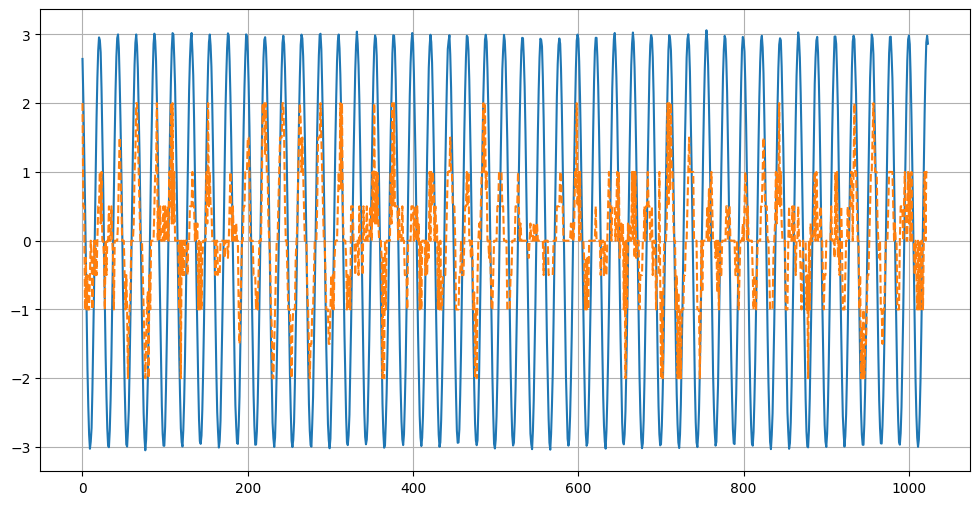

In [331]:
plt.figure(figsize=user_figsize)
plt.plot(x[N_FIG][-N_FFT:])
plt.plot(x_compr_2D_zg_rev[N_FIG], '--')
plt.grid()
plt.show()

In [332]:
N_FREQ = 40
# Bar width and positions
width = 1.0
x_pos = np.arange(len(freq[:N_FREQ]))

plt.bar(x_pos - width/2, np.abs(Xfft[:N_FREQ]), width, label='x', alpha=0.7)
plt.bar(x_pos + width/2, np.abs(Yfft[:N_FREQ]), width, label='y', alpha=0.7)

plt.xlabel('Frequency Index')
plt.ylabel('Magnitude')
plt.title('FFT Comparison - Side-by-Side Bars')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'Xfft' is not defined

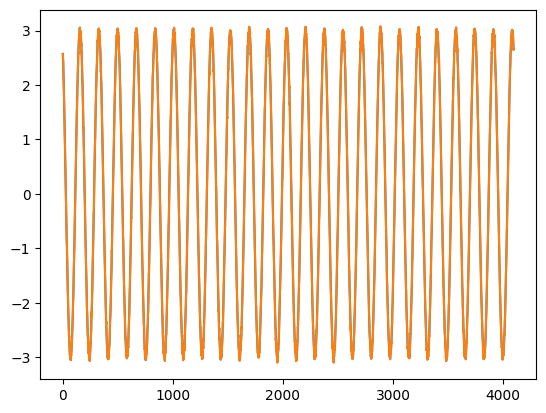

0.0


In [ ]:
x_tmp = x[5].reshape(32, -1)
x_rec = x_tmp.ravel()
print(np.sum((x[5]-x_rec)**2))
plt.plot(x[5])
plt.plot(x_rec)
plt.show()
